# WikiRecs Part 1 - Data Ingestion, Loading and Cleaning
> In this first part of the two part series, we will handle the data side. We will fetch data from wikipedia, store in feather format and register the combined data on recochef. After that, we will perform EDA and extensive cleaning.

- toc: true
- badges: true
- comments: true
- categories: [Ingestion, EDA, DataCleaning]
- author: "<a href='https://towardsdatascience.com/how-can-you-tell-if-your-recommender-system-is-any-good-e4a6be02d9c2'>Daniel Saunders</a>"
- image:

## Data ingestion

Downloading data from Wikipedia using Wiki API and storing in Google drive. There are more than 11 millions records which would take 6-8 hours in single colab session, so used 10 colab workers to fetch all the data within 30-40 mins.

In [ ]:
!git clone https://github.com/sparsh-ai/reco-wikirecs
%cd /content/reco-wikirecs/
!pip install -r requirements.txt

In [89]:
import yaml
import os
from wiki_pull import *
from itables.javascript import load_datatables
load_datatables()

In [81]:
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [9]:
get_sample_of_users(config['edit_lookback'], config['outfile'])

1000500it [07:04, 2379.90it/s]                             

Earliest timestamp: 2021-06-21T19:22:49Z
Latest timestamp: 2021-07-08T14:39:42Z
Number of distinct users: 54355
Mean number of edits per user in timeframe: 18.40
Number of distinct pages edited: 401926
Mean number of edits per page in timeframe: 2.49


,user,userid
0,Rodimus Rhyme,7021208.0
1,Asarlaí,3215664.0
2,Frank Anchor,4659544.0
3,MAHosieAPS,40684241.0
4,Aranya,35393771.0
...,...,...
54349,Penwhale,125125.0
54350,Htetrasme,174367.0
54351,LarTram,39905917.0
54352,Etan J. Tal,7706243.0


### Start the ingestion

I ran the same code from start till this cell, in 10 different colab notebooks, changing start position. The design is a master-worker setup where 1 notebooks was the master one, and 9 are workers.

In master, start=0. In worker 1, start=5000. In worker 2, start=10000, and so on. This start value indicates the number of users. Since there are 54K users, each worker handled 5000 users on average.

In [ ]:
pull_edit_histories(
    config['outfile'],
    os.path.join(config['file_save_path'],config['edit_histories_file_pattern']),
    config['users_per_chunk'],
    config['earliest_timestamp'],
    start=0,
    )

## Data storage

During ingestion, we stored data in feather format parts. Now, we will combine the data and store in compressed parquet format. 

We will also register this data on recochef so that we can easily load it anywhere and also make it reusable for future use cases.

In [ ]:
import os
import yaml
import pandas as pd
from pyarrow import feather

In [ ]:
with open('config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
all_histories = []
for fname in os.listdir(config['file_save_path']):
    if 'feather' in  fname:
        all_histories.append(feather.read_feather(os.path.join(config['file_save_path'],fname)))

In [ ]:
all_histories = pd.concat(all_histories, ignore_index=True)

In [ ]:
all_histories.head()

,userid,user,pageid,title,timestamp,sizediff
0,430714,Eyetie,22864890,List of Samuel L. Jackson performances,2021-07-08T15:01:39Z,-19
1,430714,Eyetie,2879406,Jeff Corey,2021-07-07T11:06:50Z,-13
2,430714,Eyetie,17130609,Antonio Soda,2021-07-05T11:18:51Z,1
3,430714,Eyetie,13270752,Mr In-Between,2021-06-21T16:48:00Z,-48
4,430714,Eyetie,6816331,San Giovanni Gemini,2021-06-15T20:40:18Z,3378


In [ ]:
all_histories.shape

(11081889, 6)

In [ ]:
all_histories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11081889 entries, 0 to 11081888
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userid     int64 
 1   user       object
 2   pageid     int64 
 3   title      object
 4   timestamp  object
 5   sizediff   int64 
dtypes: int64(3), object(3)
memory usage: 507.3+ MB


In [ ]:
all_histories.describe()

,userid,pageid,sizediff
count,1.108189e+07,1.108189e+07,1.108189e+07
mean,1.919552e+07,3.240817e+07,1.098695e+02
std,1.493577e+07,2.626137e+07,2.726467e+03
min,2.000000e+00,1.200000e+01,-1.251584e+06
25%,4.390460e+06,3.908644e+06,-4.000000e+00
50%,1.748758e+07,3.087424e+07,9.000000e+00
75%,3.419332e+07,6.147069e+07,6.500000e+01
max,4.214195e+07,6.818951e+07,9.116030e+05


In [ ]:
all_histories.describe(include=['O'])

,user,title,timestamp
count,11081889,11081889,11081889
unique,52614,2461545,7275769
top,BrownHairedGirl,Deaths in 2021,2021-05-01T16:48:50Z
freq,101279,9709,206


In [ ]:
all_histories.to_parquet('wikirecs.parquet.gzip', compression='gzip')

> Note: Data is also registered with [recochef](https://github.com/sparsh-ai/recochef/blob/master/src/recochef/datasets/wikirecs.py) for easy access

## EDA and Data cleaning

In [ ]:
!git clone https://github.com/sparsh-ai/reco-wikirecs
%cd /content/reco-wikirecs/
!pip install -r requirements.txt

!pip install -q git+https://github.com/sparsh-ai/recochef.git

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix, coo_matrix

from recochef.datasets.wikirecs import WikiRecs

from utils import *
from wiki_pull import *

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Data loading

In [ ]:
wikidata = WikiRecs()

In [ ]:
df = wikidata.load_interactions()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11081889 entries, 0 to 11081888
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   USERID     int64 
 1   USERNAME   object
 2   ITEMID     int64 
 3   TITLE      object
 4   TIMESTAMP  object
 5   SIZEDIFF   int64 
dtypes: int64(3), object(3)
memory usage: 507.3+ MB


In [ ]:
df.head()

,USERID,USERNAME,ITEMID,TITLE,TIMESTAMP,SIZEDIFF
0,430714,Eyetie,22864890,List of Samuel L. Jackson performances,2021-07-08T15:01:39Z,-19
1,430714,Eyetie,2879406,Jeff Corey,2021-07-07T11:06:50Z,-13
2,430714,Eyetie,17130609,Antonio Soda,2021-07-05T11:18:51Z,1
3,430714,Eyetie,13270752,Mr In-Between,2021-06-21T16:48:00Z,-48
4,430714,Eyetie,6816331,San Giovanni Gemini,2021-06-15T20:40:18Z,3378


### EDA

Median edit counts: 11
Number over threshold 5: 32145 (61%)


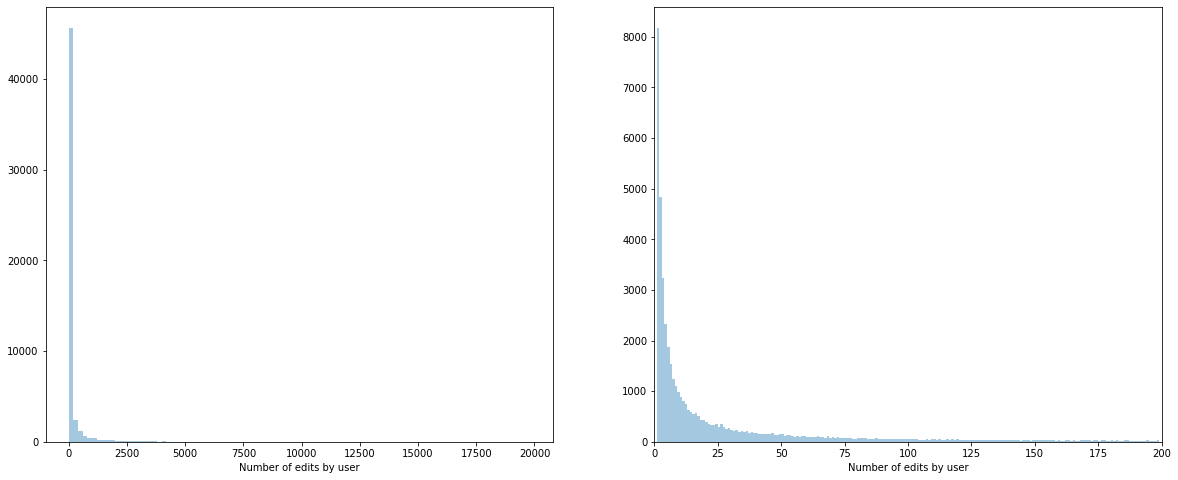

In [ ]:
# Look at the distribution of edit counts
edit_counts = df.groupby('USERID').USERID.count().values

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(edit_counts,kde=False,bins=np.arange(0,20000,200))
plt.xlabel('Number of edits by user')
plt.subplot(1,2,2)
sns.distplot(edit_counts,kde=False,bins=np.arange(0,200,1))
plt.xlim([0,200])
plt.xlabel('Number of edits by user')
num_counts = len(edit_counts)
print("Median edit counts: %d" % np.median(edit_counts))
thres = 5
over_thres = np.sum(edit_counts > thres)
print("Number over threshold %d: %d (%.f%%)" % (thres, over_thres, 100*over_thres/num_counts))

In [ ]:
# Most edits by user
df.groupby(['USERID','USERNAME']).USERID.count().sort_values(ascending=False)

USERID    USERNAME        
754619    BrownHairedGirl     101279
7611264   AnomieBOT            99911
1276024   Lugnuts              84352
30583402  Nikolai Kurbatov     72704
1261736   Red Director         66104
                               ...  
39991728  300kdan                  1
39988349  Kishore123123            1
39980891  Waiting seat             1
39979707  Hayley.bowling           1
35864949  SoccerMom679             1
Name: USERID, Length: 52614, dtype: int64

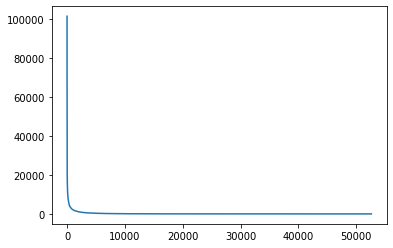

In [ ]:
# Find the elbow in number of edits
plt.plot(df.groupby(['USERID','USERNAME']).USERID.count().sort_values(ascending=False).values)
# plt.ylim([0,20000])

In [ ]:
# What are the most popular pages (edited by the most users)
page_popularity = df.drop_duplicates(subset=['TITLE','USERNAME']).groupby('TITLE').count().USERNAME.sort_values()
page_popularity.iloc[-1000:].iloc[::-1]

TITLE
2021 United States Capitol attack             730
Deaths in 2021                                461
Donald Trump                                  288
Second impeachment of Donald Trump            227
Joe Biden                                     226
                                             ... 
Pakistan                                       40
League of Legends                              40
List of coups and coup attempts by country     40
The Penthouse: War in Life                     40
Mao Zedong                                     40
Name: USERNAME, Length: 1000, dtype: int64

In [ ]:
df.sample().USERNAME

10890967    SanAnMan
Name: USERNAME, dtype: object

In [ ]:
cols = ['userid', 'user', 'pageid', 'title',
       'timestamp', 'sizediff']

oneuser = get_edit_history(user="SanAnMan",
                            latest_timestamp="2021-07-08T22:02:09Z",
                            earliest_timestamp="2020-05-28T22:02:09Z")

oneuser = pd.DataFrame(oneuser).loc[:,cols]
oneuser

,userid,user,pageid,title,timestamp,sizediff
0,14943992,SanAnMan,33275261,Disney's My Son Pinocchio: Geppetto's Musical ...,2021-07-08T15:16:51Z,59
1,14943992,SanAnMan,67347035,MasterChef (American season 11),2021-07-07T17:59:42Z,0
2,14943992,SanAnMan,35968550,MasterChef (American season 1),2021-07-07T13:32:53Z,-39
3,14943992,SanAnMan,39462622,MasterChef (American season 4),2021-07-05T23:19:07Z,4
4,14943992,SanAnMan,224267,List of South Park episodes,2021-07-04T22:09:14Z,-449
...,...,...,...,...,...,...
955,14943992,SanAnMan,37028949,Christine Hà,2020-05-29T15:09:12Z,2
956,14943992,SanAnMan,64108835,Christine Ha,2020-05-29T15:07:58Z,74
957,14943992,SanAnMan,37028949,Christine Hà,2020-05-29T15:07:57Z,0
958,14943992,SanAnMan,39462622,MasterChef (American season 4),2020-05-29T10:34:08Z,-115


### Data cleaning

#### Remove consecutive edits and summarize runs

In [ ]:
%%time
def remove_consecutive_edits(df):
    c = dict(zip(df.columns, range(len(df.columns))))
    
    keyfunc = lambda x: (x[c['USERID']],x[c['ITEMID']])
    first_and_last = lambda run: [run[0][c['USERID']],
                                run[0][c['USERNAME']],
                                run[0][c['ITEMID']],
                                run[0][c['TITLE']],
                                run[-1][c['TIMESTAMP']],
                                run[0][c['TIMESTAMP']],
                                sum([abs(r[c['SIZEDIFF']]) for r in run]),
                                len(run)]
    d  = df.values.tolist()
    return pd.DataFrame([first_and_last(list(g)) for k,g in itertools.groupby(d, key=keyfunc)], 
                        columns=['USERID', 'USER', 'ITEMID', 'TITLE', 'FIRST_TIMESTAMP', 'LAST_TIMESTAMP','SUM_SIZEDIFF','CONSECUTIVE_EDITS'])
                        
clean_df = remove_consecutive_edits(df)

CPU times: user 58.4 s, sys: 2.15 s, total: 1min
Wall time: 1min


#### Remove top N most popular pages

In [ ]:
# Get the top most popular pages
TOPN = 20
popularpages = df.drop_duplicates(subset=['TITLE','ITEMID','USERID']).groupby(['TITLE','ITEMID']).count().USERNAME.sort_values()[-TOPN:]
popularpages

TITLE                                                  ITEMID  
93rd Academy Awards                                    63807881    150
2021 Myanmar coup d'état                               66567997    151
Death and funeral of Prince Philip, Duke of Edinburgh  67349313    156
WandaVision                                            59082207    158
2020 United States presidential election               48410011    168
2021 Suez Canal obstruction                            67204875    168
Eurovision Song Contest 2021                           62877212    172
Zack Snyder's Justice League                           64017869    172
COVID-19 vaccine                                       63319438    187
2021 Israel–Palestine crisis                           67620503    189
COVID-19 pandemic                                      62750956    190
Prince Philip, Duke of Edinburgh                       62093       191
GameStop short squeeze                                 66516682    209
Surfside cond

In [ ]:
# Remove those popular pages
before_count = len(df)
popular_pageids = popularpages.index.get_level_values(level='ITEMID').values
is_popular_page_edit = clean_df.ITEMID.isin(popular_pageids)
clean_df = clean_df.loc[~is_popular_page_edit].copy()
all_histories = None
after_count = len(clean_df)
print("%d edits (%.1f%%) were in top %d popular pages. Length after removing: %d" % (np.sum(is_popular_page_edit), 
                                                                                     100* np.sum(is_popular_page_edit)/before_count,
                                                                                     TOPN,
                                                                                     after_count)
     )

19231 edits (0.2%) were in top 20 popular pages. Length after removing: 7604316


In [ ]:
print("Number of unique page ids: {}".format(len(clean_df.ITEMID.unique())))

Number of unique page ids: 2461524


#### Remove users with too many or too few edits

In [ ]:
MIN_EDITS = 5
MAX_EDITS = 10000

In [ ]:
# Get user edit counts
all_user_edit_counts = clean_df.groupby(['USERID','USER']).USERID.count()

# Remove users with too few edits
keep_user = all_user_edit_counts.values >= MIN_EDITS

# Remove users with too many edits
keep_user = keep_user & (all_user_edit_counts.values <= MAX_EDITS)

# Remove users with "bot" in the name
is_bot = ['bot' in username.lower() for username in all_user_edit_counts.index.get_level_values(1).values]
keep_user = keep_user & ~np.array(is_bot)
print("Keep %d users out of %d (%.1f%%)" % (np.sum(keep_user), len(all_user_edit_counts), 100*float(np.sum(keep_user))/len(all_user_edit_counts)))

Keep 28091 users out of 52593 (53.4%)


In [ ]:
# Remove those users
userids_to_keep = all_user_edit_counts.index.get_level_values(0).values[keep_user]

clean_df = clean_df.loc[clean_df.USERID.isin(userids_to_keep)]

clean_df = clean_df.reset_index(drop=True)

In [ ]:
print("Length after removing users: {}".format(len(clean_df)))

Length after removing users: 5907255


### Build lookup tables

In [ ]:
# Page id to title and back
lookup = clean_df.drop_duplicates(subset=['ITEMID']).loc[:,['ITEMID','TITLE']]
p2t = dict(zip(lookup.ITEMID, lookup.TITLE))
t2p = dict(zip(lookup.TITLE, lookup.ITEMID))

# User id to name and back
lookup = clean_df.drop_duplicates(subset=['USERID']).loc[:,['USERID','USER']]
u2n = dict(zip(lookup.USERID, lookup.USER))
n2u = dict(zip(lookup.USER, lookup.USERID))

In [ ]:
# Page id and userid to index in cooccurence matrix and back
pageids = np.sort(clean_df.ITEMID.unique())
userids = np.sort(clean_df.USERID.unique())
 
p2i = {pageid:i for i, pageid in enumerate(pageids)}
u2i = {userid:i for i, userid in enumerate(userids)}


i2p = {v: k for k, v in p2i.items()}
i2u = {v: k for k, v in u2i.items()}

In [ ]:
# User name and page title to index and back
n2i = {k:u2i[v] for k, v in n2u.items() if v in u2i}
t2i = {k:p2i[v] for k, v in t2p.items() if v in p2i}

i2n = {v: k for k, v in n2i.items()}
i2t = {v: k for k, v in t2i.items()}

### Build test and training set

In [ ]:
# Make a test set from the most recent edit by each user
histories_test = clean_df.groupby(['USERID','USER'],as_index=False).first()

In [ ]:
# Subtract it from the rest to make the training set
histories_train = dataframe_set_subtract(clean_df, histories_test)
histories_train.reset_index(drop=True, inplace=True)

In [ ]:
# Make a dev set from the second most recent edit by each user
histories_dev = histories_train.groupby(['USERID','USER'],as_index=False).first()
# Subtract it from the rest to make the final training set
histories_train = dataframe_set_subtract(histories_train, histories_dev)
histories_train.reset_index(drop=True, inplace=True)

In [ ]:
print("Length of test set: {}".format(len(histories_test)))
print("Length of dev set: {}".format(len(histories_dev)))
print("Length of training after removal of test: {}".format(len(histories_train)))

Length of test set: 28091
Length of dev set: 28091
Length of training after removal of test: 5849876


In [ ]:
print("Number of pages in training set: {}".format(len(histories_train.ITEMID.unique())))
print("Number of users in training set: {}".format(len(histories_train.USERID.unique())))
print("Number of pages with > 1 user editing: {}".format(np.sum(histories_train.drop_duplicates(subset=['TITLE','USER']).groupby('TITLE').count().USER > 1)))

Number of pages in training set: 1962283
Number of users in training set: 28090
Number of pages with > 1 user editing: 644980


In [ ]:
resurface_userids, discovery_userids = get_resurface_discovery(histories_train, histories_dev)

print("%d out of %d userids are resurfaced (%.1f%%)" % (len(resurface_userids), len(userids), 100*float(len(resurface_userids))/len(userids)))
print("%d out of %d userids are discovered (%.1f%%)" % (len(discovery_userids), len(userids), 100*float(len(discovery_userids))/len(userids)))

7760 out of 28090 userids are resurfaced (27.6%)
20330 out of 28090 userids are discovered (72.4%)


### Build matrix for implicit collaborative filtering

In [ ]:
# Get the user/page edit counts
for_implicit = histories_train.groupby(["USERID","ITEMID"]).count().FIRST_TIMESTAMP.reset_index().rename(columns={'FIRST_TIMESTAMP':'edits'})
for_implicit.loc[:,'edits'] = for_implicit.edits.astype(np.int32)

In [ ]:
row = np.array([p2i[p] for p in for_implicit.ITEMID.values])
col = np.array([u2i[u] for u in for_implicit.USERID.values])

implicit_matrix_coo = coo_matrix((for_implicit.edits.values, (row, col)))

implicit_matrix = csc_matrix(implicit_matrix_coo)

### Saving artifacts

In [ ]:
save_pickle((p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t), 'lookup_tables.pickle')
save_pickle((userids, pageids), 'users_and_pages.pickle')
save_pickle((resurface_userids, discovery_userids), 'resurface_discovery_users.pickle')
save_pickle(implicit_matrix,'implicit_matrix.pickle')